In [1]:
# Load required libraries
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from dask.distributed import Client, LocalCluster
import pyproj
import numpy as np
import pandas as pd
import xarray as xr
import itertools
import verde as vd
# Load our custom gridder and utility functions
from vectorspline3d import VectorSpline3D, VectorSpline3DCV
from vectorspline3d.utils import DummyGridder

In [2]:
client = Client(LocalCluster(n_workers=2, threads_per_worker=2))
client

Client Scheduler: tcp://127.0.0.1:41007 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 8.37 GB


In [3]:
data = pd.read_csv("../../data/tibet-gps.csv", na_values="-").dropna().reset_index(drop=True)
print(vd.get_region((data.longitude, data.latitude)))
data.up_velocity *= 1
data.describe()

(75.23, 109.82, 13.02, 47.87)


,longitude,latitude,north_velocity,north_velocity_std,east_velocity,east_velocity_std,up_velocity,up_velocity_std
count,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000
mean,99.575956,33.430244,0.644889,0.757444,6.648222,0.762489,1.418222,1.401422
std,6.943382,4.956728,10.143781,0.172611,5.222720,0.167667,1.537121,0.318298
min,75.230000,13.020000,-15.900000,0.160000,-7.400000,0.160000,-3.800000,0.510000
25%,98.025000,29.547500,-4.200000,0.700000,3.400000,0.710000,0.500000,1.190000
50%,101.630000,34.350000,-0.950000,0.720000,5.800000,0.720000,1.600000,1.490000
75%,104.050000,37.317500,2.500000,0.920000,8.875000,0.920000,2.500000,1.540000
max,109.820000,47.870000,37.900000,1.190000,26.700000,1.190000,4.900000,2.400000


In [4]:
region = (73, 112, 19, 46)
#region = (95, 112, 19, 46)
data = data[vd.inside((data.longitude, data.latitude), region)]

coordinates = (data.longitude.values, data.latitude.values)
components = (data.east_velocity, data.north_velocity, data.up_velocity)
uncertainty = (data.east_velocity_std, data.north_velocity_std, data.up_velocity_std)
weights = tuple(w*vd.variance_to_weights(u**2) for w, u in zip([0.01, 0.01, 1], uncertainty))

ndata = data.shape[0]
print(ndata)
spacing = 0.25

projection = pyproj.Proj(proj="merc", lon_0=data.longitude.mean())
proj_coords = projection(*coordinates)

447


In [5]:
def plot_data(data, ax=None, maxabs=5, every_arrow=5, quiver_scale=200, quiver_width=0.0015, size=50):
    "Plot a grid or a DataFrame with the vertical in color and horizontal as vectors."
    crs = ccrs.Mercator()
    transform = ccrs.PlateCarree()
    if ax is None:
        plt.figure(figsize=(13, 16))
        ax = plt.subplot(111, projection=crs)
    #ax.add_feature(cfeature.GSHHSFeature(), facecolor="gray", zorder=-1)
    ax.add_feature(cfeature.LAND, facecolor="gray")
    #ax.stock_img()
    cbargs = dict(orientation="horizontal", aspect=50, label="vertical velocity (mm/yr)",
                  shrink=0.8, pad=0.05)
    if isinstance(data, pd.DataFrame):
        tmp = ax.scatter(
            data.longitude, data.latitude, s=size, c=data.up_velocity,
            vmin=-maxabs, vmax=maxabs, cmap="seismic", transform=transform
        )
        plt.colorbar(tmp, ax=ax, **cbargs)        
    else:
        data.up_velocity.plot.pcolormesh(
            ax=ax, vmin=-maxabs, vmax=maxabs, cmap="seismic", cbar_kwargs=cbargs, 
            add_labels=False, transform=transform
        )
        indexer = slice(None, None, every_arrow)
        # Downsample the arrows so we can actually see something
        data = data.isel(longitude=indexer, latitude=indexer)
    ax.quiver(data.longitude.values, data.latitude.values, 
              data.east_velocity.values, data.north_velocity.values, 
              scale=quiver_scale, width=quiver_width, transform=transform)
    #ax.coastlines(resolution="50m", linewidth=1)
    # Set the proper ticks for a Cartopy map
    ax.set_xticks(np.arange(*region[:2], 3)[1:], crs=transform)
    ax.set_yticks(np.arange(*region[2:], 3)[1:], crs=transform)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.set_extent(region, crs=transform)    
    return ax

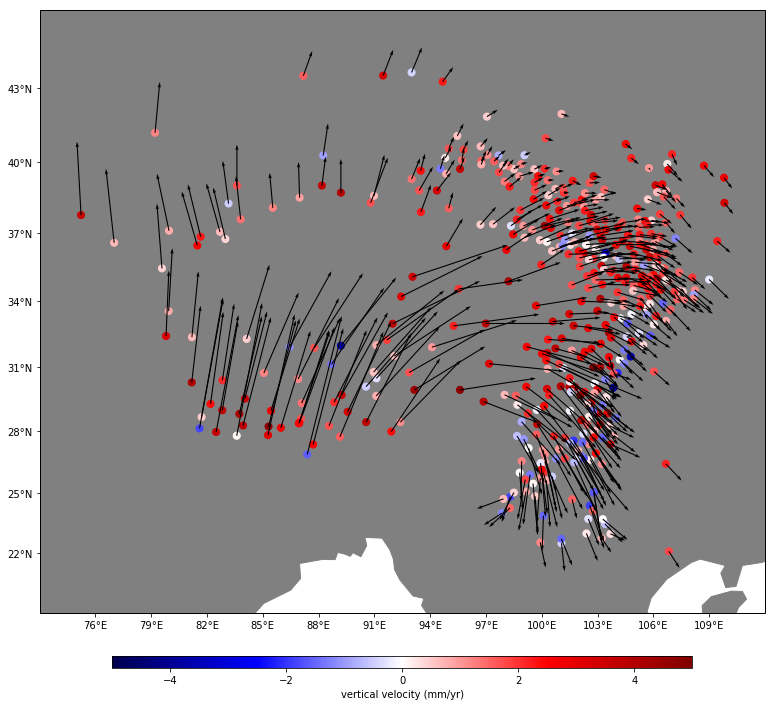

In [6]:
plot_data(data)

In [7]:
blockmean = vd.BlockReduce(np.mean, spacing=spacing*111e3, center_coordinates=False)
force_coords = blockmean.filter(proj_coords, np.ones(ndata))[0]
print(force_coords[0].size)

436


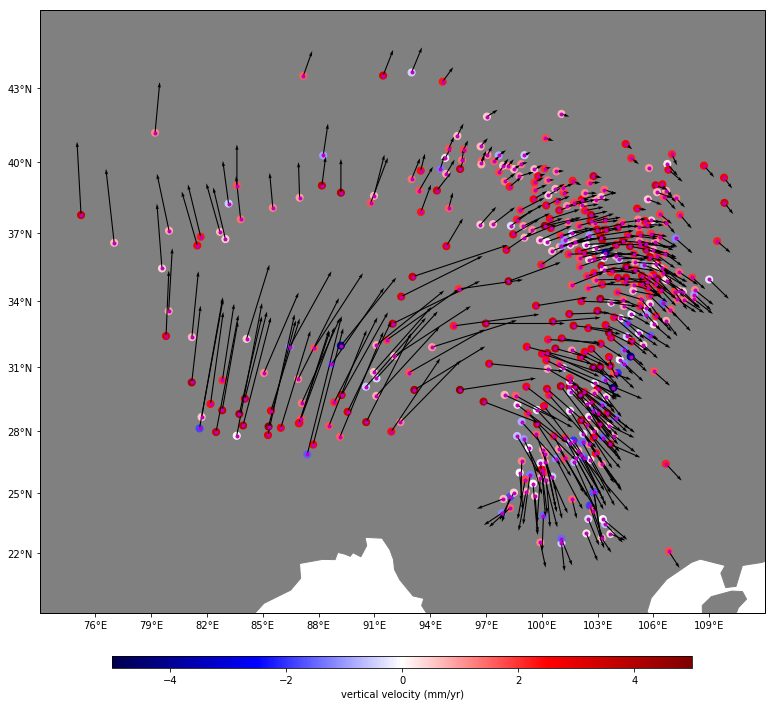

In [8]:
ax = plot_data(data)
ax.plot(*projection(*force_coords, inverse=True), ".m", transform=ccrs.PlateCarree())

In [13]:
%%time
spline = VectorSpline3DCV(
    poissons=[-1, -0.5, 0, 0.25, 0.5],
    dampings=[1e-4, 1e-3, 1e-2, 0.5, 0.1, 1],
    depths=[25e3, 50e3, 100e3, 150e3, 200e3, 250e3, 300e3, 350e3, 400e3, 450e3, 500e3],
    couplings=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1],
    #poissons=[-1],
    #dampings=[1e-4],
    #depths=[10e3],
    #couplings=[-1],
    force_coords=force_coords,
    client=client,
)
spline.fit(proj_coords, components, weights)
print("Best spline configuration:\n", spline.gridder_)
print("Best score:", spline.scores_.max())
print("Score on training set:", spline.score(proj_coords, components, weights))

Best spline configuration:
 VectorSpline3D(coupling=0, damping=0.1, depth=350000.0, depth_scale='nearest',
        force_coords=(array([ 798661.31314,   29443.63176, ..., -911206.06544, -740887.24453]), array([2508661.29285, 2561309.21768, ..., 5355909.05678, 5374272.03415])),
        poisson=0.5)
Best score: 0.6436124072695508
Score on training set: 0.7875683299954878
CPU times: user 3min 20s, sys: 8.61 s, total: 3min 29s
Wall time: 16min 12s


/home/leo/miniconda3/envs/agu2018/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1752: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/leo/miniconda3/envs/agu2018/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1752: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


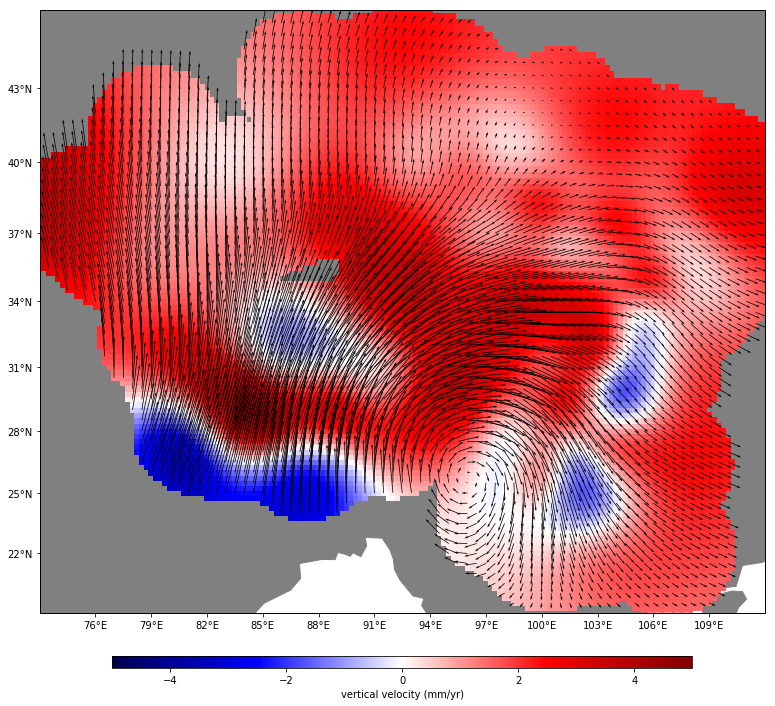

In [14]:
grid = spline.grid(
    region=region,
    spacing=spacing, 
    projection=projection,
    dims=["latitude", "longitude"],
    data_names=["east_velocity", "north_velocity", "up_velocity"]
)
grid = vd.distance_mask(coordinates, maxdist=400e3, grid=grid, projection=projection)

plot_data(grid, every_arrow=2, quiver_width=0.001, quiver_scale=300)

In [11]:
%%time
dampings = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
mindists = [50e3, 100e3, 150e3, 200e3, 250e3, 300e3, 350e3, 400e3, 450e3, 500e3]

parameter_combinations = [
    dict(zip(["damping", "mindist"], combo))
    for combo in itertools.product(dampings, mindists)
]

scores = []
for parameters in parameter_combinations:
    candidate = vd.Vector([
        vd.Spline(force_coords=force_coords, **parameters)
        for i in range(3)
    ])
    scores.append(client.submit(
        vd.cross_val_score,
        candidate,
        proj_coords,
        components,
        weights=weights,
    ))
scores = [np.mean(i.result()) for i in scores]
best = np.argmax(scores)
best_parameters = parameter_combinations[best]
spline_single = vd.Vector([
    vd.Spline(force_coords=force_coords, **best_parameters)
    for i in range(3)
]).fit(proj_coords, components, weights=weights)
print("Best parameters:", best_parameters)
print("Best score:", scores[best])
print("Score on training set:", spline_single.score(proj_coords, components, weights=weights))

Best parameters: {'damping': 0.0001, 'mindist': 250000.0}
Best score: 0.6481130433221838
Score on training set: 0.8665842665784226
CPU times: user 3.92 s, sys: 652 ms, total: 4.58 s
Wall time: 13.6 s


/home/leo/miniconda3/envs/agu2018/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1752: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/leo/miniconda3/envs/agu2018/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1752: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


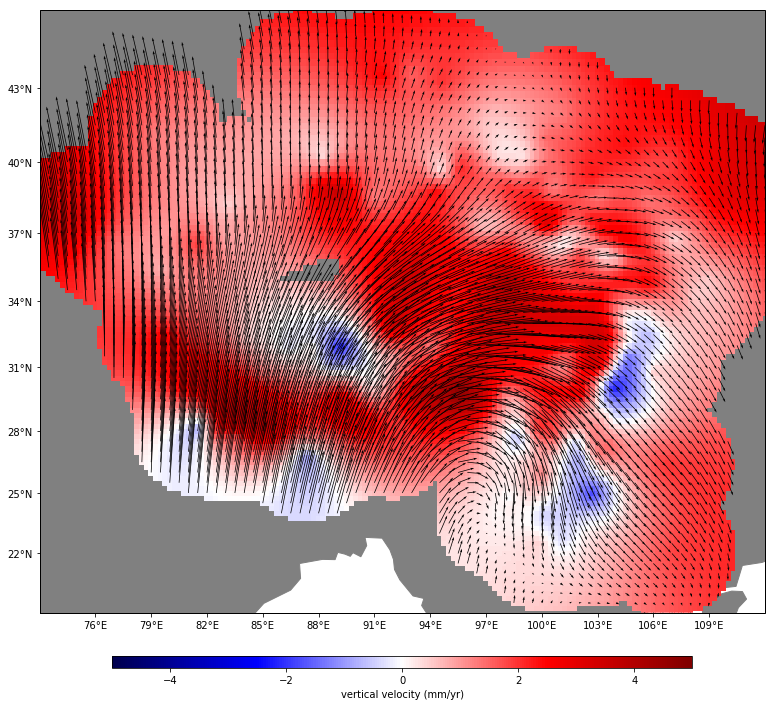

In [12]:
grid_single = spline_single.grid(
    region=region,
    spacing=spacing, 
    projection=projection,
    dims=["latitude", "longitude"],
    data_names=["east_velocity", "north_velocity", "up_velocity"]
)
grid_single = vd.distance_mask(coordinates, maxdist=400e3, grid=grid_single, projection=projection)

plot_data(grid_single, every_arrow=2, quiver_width=0.001, quiver_scale=300)